In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
import time
from collections import namedtuple, deque
import random
from matplotlib import pyplot as plt
import pickle

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
class DuellingDQN(nn.Module):
    def __init__(self,
                 num_states = 4,
                 num_actions = 2,
                 hidden_size1 = 64,
                 hidden_size2 = 128,
                 Case = 'Avg'):
        self.Case = Case
        super(DuellingDQN, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(num_states, hidden_size1),
                                 nn.ReLU())
        self.val = nn.Sequential(nn.Linear(hidden_size1,hidden_size2),
                                 nn.ReLU(),
                                 nn.Linear(hidden_size2,1))
        self.adv = nn.Sequential(nn.Linear(hidden_size1,hidden_size2),
                                 nn.ReLU(),
                                 nn.Linear(hidden_size2,num_actions))

    def forward(self,x):
        out_1 = self.fc1(x)
        val_out = self.val(out_1) 
        adv_out = self.adv(out_1)

        if self.Case == 'Avg':
            adv_ = torch.mean(adv_out, dim = -1)
            adv_ = torch.unsqueeze(adv_,-1)

        if self.Case == 'Max':
            adv_,_ = torch.max(adv_out, dim = -1)
            adv_ = torch.unsqueeze(adv_,-1)
        Q_val = val_out + (adv_out- adv_)

        return Q_val.type(torch.DoubleTensor)


In [4]:
class MemoryBuffer():
    def __init__(self,buffer_size, batch_size):
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        #self.num_action = num_action
        self.experience= namedtuple('env_data',['curr_state', 'action','reward','next_state','done'])
        self.memory_deque = deque(maxlen = self.buffer_size)

    def add_experience(self,curr_state, action, reward, next_state,done):
        self.memory_deque.append(self.experience(curr_state, action, reward, next_state, done))

    def sample(self):
        sampled_experience = random.sample(self.memory_deque,k = self.batch_size)
        curr_states = torch.from_numpy(np.vstack([sampled_experience[i].curr_state for i in range(len(sampled_experience))]))
        next_states = torch.from_numpy(np.vstack([sampled_experience[i].next_state for i in range(len(sampled_experience))]))
        rewards = torch.from_numpy(np.vstack([sampled_experience[i].reward for i in range(len(sampled_experience))]))
        actions = torch.from_numpy(np.vstack([sampled_experience[i].action for i in range(len(sampled_experience))]))
        dones = torch.from_numpy(np.vstack([sampled_experience[i].done for i in range(len(sampled_experience))]))

        return curr_states, actions, rewards, next_states, dones



In [5]:
class Agent_DQN():
    def __init__(self, env,
                 num_actions,
                 num_states,
                 gamma = 0.99,
                 batch_size = 64,
                 lr = 1e-2,
                 hidden_size1 = 64,
                 hidden_size2 = 128,
                 Case = 'Avg',
                 eps_greedy = True):
        self.env = env
        self.num_actions = num_actions
        self.num_states = num_states
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.eps_greedy = eps_greedy
        #self.policy_param = policy_param
        self.batch_size = batch_size
        self.gamma = gamma

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.gamma = torch.tensor(self.gamma).to(self.device)

        self.onlineQNet = DuellingDQN(num_states=self.num_states,
                                      num_actions= self.num_actions,
                                      hidden_size1=self.hidden_size1,
                                      hidden_size2=self.hidden_size2,
                                      Case = Case).to(self.device)
        self.targetQnet = DuellingDQN(num_states=self.num_states,
                                      num_actions= self.num_actions,
                                      hidden_size1=self.hidden_size1,
                                      hidden_size2=self.hidden_size2,
                                      Case = Case).to(self.device)

        for param in self.targetQnet.parameters():
            param.requires_grad = False

        self.targetQnet.load_state_dict(self.onlineQNet.state_dict())
        self.optimiser = torch.optim.Adam(self.onlineQNet.parameters(), lr = lr)
        self.memory_replay = MemoryBuffer(buffer_size = int(1e5), batch_size=self.batch_size)

    def choose_action(self, q_vals, epsilon):
        if self.eps_greedy == True:
            rand_num = np.random.random()
            if rand_num < epsilon:
                return np.random.choice(np.arange(self.num_actions))
            else:
                return np.argmax(q_vals.detach().numpy())

    def update_wt(self, experience):
        curr_state, action, reward, next_state,done = experience
        done = done.type('torch.DoubleTensor')

        action = action.to(self.device)
        curr_state = curr_state.to(self.device)
        next_state = next_state.to(self.device)

        reward = reward.to(self.device)
        done = done.to(self.device)

        with torch.no_grad():
            onlineQ_next = self.onlineQNet(next_state).to(self.device)
            targetQ_next = self.targetQnet(next_state).to(self.device)
            online_max_action = torch.argmax(onlineQ_next, dim=1, keepdim=True).to(self.device)
            y = reward + (1 - done) * self.gamma * targetQ_next.gather(1, online_max_action.long())
        loss = F.mse_loss(self.onlineQNet(curr_state).to(self.device).gather(1, action.long()), y)
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def train(self, epochs = 1000, update_steps = 5, epsilon = 0.1, epsilon_decay = 0.995, epsilon_min = 0.001, printing = True):
        learn_steps = 0
        score_monitor = []
        for ep in range(epochs):
            
            curr_state = self.env.reset()[0]
            done = False
            i = 0
            ep_reward = 0
            while not done:

                q_vals = self.onlineQNet(torch.tensor(curr_state, dtype = torch.float32).to(self.device))
                action = self.choose_action(q_vals, epsilon)
                next_state, reward, done, _, _ = self.env.step(action)
                ep_reward += reward
                self.memory_replay.add_experience(curr_state,action, reward, next_state,done)
                if len(self.memory_replay.memory_deque) >= self.batch_size:
                    #print(f'Training : {len(self.memory_replay.memory_deque)}')
                    batch_experience = self.memory_replay.sample()
                    self.update_wt(batch_experience)
                    learn_steps +=1
                    if learn_steps % update_steps == 0:
                        self.targetQnet.load_state_dict(self.onlineQNet.state_dict())
                        epsilon = max(epsilon_min, epsilon_decay*epsilon)
                curr_state = next_state
                i+=1
                if i>=500:
                    break
            score_monitor.append(ep_reward)
            if printing:
                if ep%1 == 0:
                    print(f'epoch = {ep}: reward = {ep_reward}')
        return score_monitor


In [ ]:
env = gym.make('Acrobot-v1', render_mode='rgb_array')
env.reset()
agent = Agent_DQN(env=env,
                  num_actions=3,
                  num_states=6,
                  gamma = 0.99,
                  batch_size = 32,
                  lr = 1e-3,
                  hidden_size1 = 64,
                  hidden_size2 = 128,
                  Case = 'Avg',
                  eps_greedy = True)

score = agent.train(epochs = 1000, update_steps = 4, epsilon = 0.1, epsilon_decay = 0.995, epsilon_min = 0.001, printing = True)

## 5 Runs

In [7]:
epochs = 1000
runs = 5
scores_runs = np.zeros((runs, epochs))
for i in range(runs):
    print(f'run = {i}')
    env = gym.make('Acrobot-v1', render_mode='rgb_array')
    env.reset()
    agent = Agent_DQN(env=env,
                    num_actions=3,
                    num_states=6,
                    gamma = 0.99,
                    batch_size = 32,
                    lr = 1e-3,
                    hidden_size1 = 64,
                    hidden_size2 = 128,
                    Case = 'Avg',
                    eps_greedy = True)

    score = agent.train(epochs = epochs, update_steps = 10, epsilon = 0.1, epsilon_decay = 0.995, epsilon_min = 0.001, printing = False)
    print(len(score), np.mean(score))
    scores_runs[i] = score

run = 0
1000 -91.838
run = 1
1000 -92.024
run = 2
1000 -92.403
run = 3
1000 -94.378
run = 4
1000 -92.028


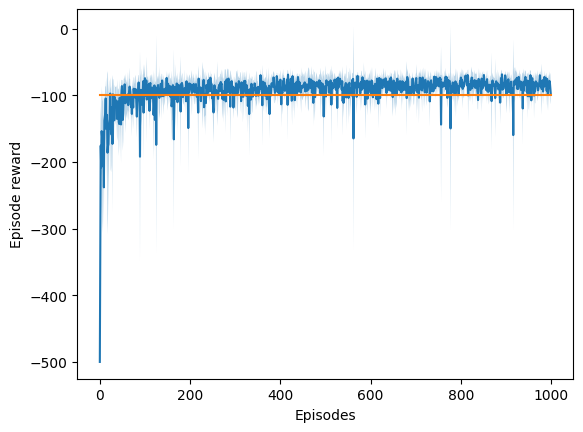

In [12]:
mean_score = np.mean(scores_runs,axis = 0)
se_score = np.std(scores_runs,axis = 0)
episode = np.arange(0,epochs)
max_line = -100* np.ones(epochs)
plt.figure()
plt.xlabel('Episodes')
plt.ylabel('Episode reward')
plt.plot(episode,mean_score)
plt.plot(episode, max_line)
plt.fill_between(episode,
                 mean_score-se_score,
                 mean_score+se_score,
                 alpha = 0.3)
#plt.ylim(0,550)
plt.show()

In [9]:
max_score = np.max(mean_score)
regret = np.sum(max_score - mean_score)/epochs
print(f'Regret = {regret}')

Regret = 24.134199999999996


In [10]:
import pickle
with open('acrobot_duelling_avg_last.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(scores_runs, file) 
